In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# import other libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from typing import *
import time
import math
import random
import wandb
wandb.login()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mantra7. Use `wandb login --relogin` to force relogin


In [5]:
# define Lang
class Lang:
	def __init__(self, wordList):
		self.char2index = {'A': 0, 'Z': 1, '_': 2, '^':3}
		self.char2count = {}
		self.index2char = {0: 'A', 1: 'Z', 2: '_', 3: '^'}
		self.n_chars = 4
		self.chars = ['A', 'Z', '_', '^']

		for word in wordList:
			self.addWord(word)

	def addWord(self, word):
		for char in word:
			self.addChar(char)

	def addChar(self, char):
		if char not in self.char2index:
			self.char2index[char] = self.n_chars
			self.char2count[char] = 1
			self.index2char[self.n_chars] = char
			self.chars.append(char)
			self.n_chars += 1
		elif char != '_' and char != '^' and char != 'A' and char != 'Z':
			self.char2count[char] += 1

	def encode_char(self, char):
		if char in self.char2index:
			return self.char2index[char]
		else:
			return self.char2index['^']

	def encode(self, word):
		encoded = [0] * len(word)
		for i in range(len(word)):
			if word[i] in self.char2index:
				encoded[i] = self.char2index[word[i]]
			else:
				encoded[i] = self.char2index['^']
		return encoded
	
	def one_hot_encode(self, word):
		one_hot = torch.zeros(len(word), self.n_chars, device=device)
		for i in range(len(word)):
			if word[i] in self.char2index:
				one_hot[i][self.char2index[word[i]]] = 1
			else:
				one_hot[i][self.char2index['^']] = 1			
		return one_hot
		
	def decode(self, word):
		decoded = ''
		for i in range(len(word)):
			if word[i].argmax().item() in self.index2char:
				decoded += self.index2char[word[i].argmax().item()]
			else:
				decoded += '^'
		return decoded
	
	def decode_words(self, words):
		n_words = words.argmax(dim=2).T
		decoded = ['']*len(n_words)
		for i in range(len(n_words)):
			decoded[i] = ''.join([self.index2char[n_words[i][j].item()] for j in range(len(n_words[i]))])

		return decoded
	
	def decode_one_hot(self, word):
		decoded = ''
		for i in range(len(word)):
			if word[i].argmax().item() in self.index2char:
				decoded += self.index2char[word[i].argmax().item()]
			else:
				decoded += '^'
		return decoded

In [6]:
def tensorFromWord(lang : Lang, word : str):
	indexes = lang.encode(word)
	return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromWords(lang : Lang, words : List[str]):
	tensors = []
	for word in words:
		tensors.append(tensorFromWord(lang, word))
	return torch.cat(tensors, dim=1)

def tensorsFromPair(pair, inp_lang : Lang, out_lang : Lang):
	input_tensor = tensorFromWord(inp_lang, pair[0])
	target_tensor = tensorFromWord(out_lang, pair[1])
	return (input_tensor.unsqueeze(1), target_tensor)

def tensorsFromPairs(pairs, inp_lang : Lang, out_lang : Lang, batch_size):
	tensors_inp = []
	tensors_out = []
	for pair in pairs:
		tensors_inp.append(tensorFromWord(inp_lang, pair[0]))
		tensors_out.append(tensorFromWord(out_lang, pair[1]))
	return torch.cat(tensors_inp, dim=1).view(-1,1,batch_size), torch.cat(tensors_out, dim=1)

In [7]:
def DataLoader(lang : str, pad : bool = False, max_length : int = 40):
	train_data = pd.read_csv(f'aksharantar_sampled/{lang}/{lang}_train.csv')
	test_data = pd.read_csv(f'aksharantar_sampled/{lang}/{lang}_test.csv')
	valid_data = pd.read_csv(f'aksharantar_sampled/{lang}/{lang}_valid.csv')
	# train_data = pd.read_csv('/kaggle/input/gujarati/guj_train.csv')
	# test_data = pd.read_csv('/kaggle/input/gujarati/guj_test.csv')
	# valid_data = pd.read_csv('/kaggle/input/gujarati/guj_valid.csv')

	train_data.columns = ['input_seq', 'target_seq']
	test_data.columns = ['input_seq', 'target_seq']
	valid_data.columns = ['input_seq', 'target_seq']
        
	train_data['input_seq'] = train_data['input_seq'].apply(lambda x: x + 'Z')
	train_data['target_seq'] = train_data['target_seq'].apply(lambda x: x + 'Z')
	test_data['input_seq'] = test_data['input_seq'].apply(lambda x: x + 'Z')
	test_data['target_seq'] = test_data['target_seq'].apply(lambda x: x + 'Z')
	valid_data['input_seq'] = valid_data['input_seq'].apply(lambda x: x + 'Z')
	valid_data['target_seq'] = valid_data['target_seq'].apply(lambda x: x + 'Z')

	if pad:
		train_data['input_seq'] = train_data['input_seq'].apply(lambda x: x + '_'*(max_length - len(x)))
		train_data['target_seq'] = train_data['target_seq'].apply(lambda x: x + '_'*(max_length - len(x)))
		test_data['input_seq'] = test_data['input_seq'].apply(lambda x: x + '_'*(max_length - len(x)))
		test_data['target_seq'] = test_data['target_seq'].apply(lambda x: x + '_'*(max_length - len(x)))
		valid_data['input_seq'] = valid_data['input_seq'].apply(lambda x: x + '_'*(max_length - len(x)))
		valid_data['target_seq'] = valid_data['target_seq'].apply(lambda x: x + '_'*(max_length - len(x)))

	return train_data, test_data, valid_data

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [8]:
def get_cell(str):
	if str == 'lstm':
		return nn.LSTM
	elif str == 'gru':
		return nn.GRU
	elif str == 'rnn':
		return nn.RNN
	else:
		raise ValueError('Invalid cell type')

In [9]:
class EncoderRNN(nn.Module):
	def __init__(self, input_size, embed_size, hidden_size, n_layers=1, type='gru', dropout=0.2, batch_size=1):
		super(EncoderRNN, self).__init__()
		self.hidden_size = hidden_size
		self.n_layers = n_layers
		self.type_t = type
		self.batch_size = batch_size

		self.embedding = nn.Embedding(input_size, embed_size)
		self.cell = get_cell(type)(embed_size, hidden_size, n_layers, dropout=dropout)

	def forward(self, input, hidden):
		embedded = self.embedding(input)
		output = embedded
		output, hidden = self.cell(output, hidden)
		return output, hidden

	def initHidden(self, bs = -1):
		if bs == -1:
			bs = self.batch_size
		if self.type_t == 'lstm':
			return torch.zeros(self.n_layers, bs, self.hidden_size, device=device), torch.zeros(self.n_layers, bs, self.hidden_size, device=device)
		else:
			return torch.zeros(self.n_layers, bs, self.hidden_size, device=device)
	
class DecoderRNN(nn.Module):
	def __init__(self, hidden_size, embed_size, output_size, n_layers=1, type='gru', dropout=0.2, batch_size=1):
		super(DecoderRNN, self).__init__()
		self.hidden_size = hidden_size
		self.embed_size = embed_size
		self.n_layers = n_layers
		self.type_t = type
		self.batch_size = batch_size

		self.embedding = nn.Embedding(output_size, embed_size)
		self.cell = get_cell(type)(embed_size, hidden_size, n_layers, dropout=dropout)
		self.out = nn.Linear(hidden_size, output_size)
		self.softmax = nn.LogSoftmax(dim=1)

	def forward(self, input, hidden, bs = -1):
		if bs == -1:
			bs = self.batch_size
		output = self.embedding(input).view(1, bs, -1)
		output = F.relu(output)
		output, hidden = self.cell(output, hidden)
		output = self.softmax(self.out(output[0]))
		return output, hidden

	def initHidden(self, bs = -1):
		if bs == -1:
			bs = self.batch_size
		if self.type_t == 'lstm':
			return torch.zeros(self.n_layers, bs, self.hidden_size, device=device), torch.zeros(self.n_layers, bs, self.hidden_size, device=device)
		else:
			return torch.zeros(self.n_layers, bs, self.hidden_size, device=device)
		

class AttnDecoderRNN(nn.Module):
	def __init__(self, hidden_size, output_size, n_layers=1, type='gru', dropout_p=0.1, batch_size=1, max_length=50):
		super(AttnDecoderRNN, self).__init__()
		self.hidden_size = hidden_size
		self.output_size = output_size
		self.dropout_p = dropout_p
		self.max_length = max_length
		self.n_layers = n_layers
		self.type_t = type
		self.batch_size = batch_size

		self.cell = get_cell(type)(hidden_size, hidden_size, n_layers, dropout=dropout_p)
		self.embedding = nn.Embedding(self.output_size, self.hidden_size)
		self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
		self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
		self.dropout = nn.Dropout(self.dropout_p)
		self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers, dropout=self.dropout_p)
		self.out = nn.Linear(self.hidden_size, self.output_size)

	def forward(self, input, hidden, encoder_outputs, bs=-1):
		if bs == -1:
			bs = self.batch_size
		embedded = self.embedding(input).view(1, bs, -1)
		embedded = self.dropout(embedded)

		if self.type_t != 'lstm':
			attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
		else:
			attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
		attn_applied = torch.bmm(attn_weights.unsqueeze(0),
								encoder_outputs.unsqueeze(0))

		output = torch.cat((embedded[0], attn_applied[0]), 1)
		output = self.attn_combine(output).unsqueeze(0)

		output = F.relu(output)
		output, hidden = self.cell(output, hidden)

		output = F.log_softmax(self.out(output[0]), dim=1)
		return output, hidden, attn_weights

	def initHidden(self, bs=-1):
		if bs == -1:
			bs = self.batch_size
		if self.type_t == 'lstm':
			return torch.zeros(self.n_layers, bs, self.hidden_size, device=device), torch.zeros(self.n_layers, bs, self.hidden_size, device=device)
		else:
			return torch.zeros(self.n_layers, bs, self.hidden_size, device=device)

In [10]:
class Seq2Seq(nn.Module):
	def __init__(self, input_size, hidden_size, embed_size, output_size, enc_layers=1, dec_layers=1, type='gru', dropout=0.2, batch_size=1, max_length=50,is_attn=False):
		super(Seq2Seq, self).__init__()
		self.input_size = input_size
		self.hidden_size = hidden_size
		self.output_size = output_size
		self.enc_layers = enc_layers
		self.dec_layers = dec_layers
		self.batch_size = batch_size
		self.dropout = dropout
		self.max_length = max_length
		self.is_attn = is_attn
		self.type_t = type

		self.encoder = EncoderRNN(input_size, embed_size, hidden_size, enc_layers, type, dropout, batch_size).to(device)
		if not is_attn:
			self.decoder = DecoderRNN(hidden_size, embed_size, output_size, dec_layers, type, dropout, batch_size).to(device)
		else:
			self.decoder = AttnDecoderRNN(hidden_size, output_size, dec_layers, type, dropout, batch_size, max_length).to(device)

	def forward(self, input_tensor, target_tensor):
		bs = input_tensor.size(2)
		encoder_hidden = self.encoder.initHidden(bs)

		input_length = input_tensor.size(0)
		target_length = target_tensor.size(0)

		encoder_outputs = torch.zeros(self.max_length, self.encoder.hidden_size, device=device)

		for ei in range(input_length):
			encoder_output, encoder_hidden = self.encoder(
				input_tensor[ei], encoder_hidden)
			encoder_outputs[ei] = encoder_output[0, 0]

		lst = []
		for i in range(bs):
			lst.append([0])
		decoder_input = torch.tensor(lst, device=device)  # SOS

		if self.encoder.n_layers == self.decoder.n_layers:
			decoder_hidden = encoder_hidden
		elif self.type_t != 'lstm':
			decoder_hidden = torch.zeros(self.decoder.n_layers, bs, self.decoder.hidden_size, device=device)
			av = encoder_hidden[0]
			for i in range(1,self.encoder.n_layers):
				av += encoder_hidden[i]
			av /= self.encoder.n_layers
			for i in range(self.decoder.n_layers):
				decoder_hidden[i] = av
		else:
			decoder_hidden = (torch.zeros(self.decoder.n_layers, bs, self.decoder.hidden_size, device=device), torch.zeros(self.decoder.n_layers, bs, self.decoder.hidden_size, device=device))
			av = encoder_hidden[0][0]
			for i in range(1,self.encoder.n_layers):
				av += encoder_hidden[0][i]
			av /= self.encoder.n_layers
			for i in range(self.decoder.n_layers):
				decoder_hidden[0][i] = av
			av = encoder_hidden[1][0]
			for i in range(1,self.encoder.n_layers):
				av += encoder_hidden[1][i]
			av /= self.encoder.n_layers
			for i in range(self.decoder.n_layers):
				decoder_hidden[1][i] = av

		use_teacher_forcing = True if random.random() < 0.5 else False

		decoder_outputs = torch.zeros(target_length, bs, self.output_size, device=device)
		if not self.is_attn:
			if use_teacher_forcing:
				# Teacher forcing: Feed the target as the next input
				for di in range(target_length):
					decoder_output, decoder_hidden = self.decoder(
						decoder_input, decoder_hidden, bs)
					decoder_outputs[di] = decoder_output
					decoder_input = target_tensor[di]  # Teacher forcing
			else:
				# Without teacher forcing: use its own predictions as the next input
				for di in range(target_length):
					decoder_output, decoder_hidden = self.decoder(
						decoder_input, decoder_hidden, bs)
					decoder_outputs[di] = decoder_output
					topv, topi = decoder_output.topk(1)
					decoder_input = topi.squeeze().detach()  # detach from history as input
					if self.batch_size == 1:
						if topi == 1:
							break
		else:
			if use_teacher_forcing:
				# Teacher forcing: Feed the target as the next input
				for di in range(target_length):
					decoder_output, decoder_hidden, decoder_attention = self.decoder(
						decoder_input, decoder_hidden, encoder_outputs, bs)
					decoder_outputs[di] = decoder_output
					decoder_input = target_tensor[di]
			else:
				# Without teacher forcing: use its own predictions as the next input
				for di in range(target_length):
					decoder_output, decoder_hidden, decoder_attention = self.decoder(
						decoder_input, decoder_hidden, encoder_outputs, bs)
					decoder_outputs[di] = decoder_output
					topv, topi = decoder_output.topk(1)
					decoder_input = topi.squeeze().detach()
					if self.batch_size == 1:
						if topi == 1:
							break

		return decoder_outputs

	def predict(self, input_tensor):
		encoder_hidden = self.encoder.initHidden(1)

		input_length = input_tensor.size(0)

		encoder_outputs = torch.zeros(self.max_length, self.encoder.hidden_size, device=device)

		for ei in range(input_length):
			encoder_output, encoder_hidden = self.encoder(
				input_tensor[ei], encoder_hidden)
			encoder_outputs[ei] = encoder_output[0, 0]

		decoder_input = torch.tensor([[0]], device=device)  # SOS

		decoder_outputs = []

		if self.encoder.n_layers == self.decoder.n_layers:
			decoder_hidden = encoder_hidden
		elif self.type_t != 'lstm':
			decoder_hidden = torch.zeros(self.decoder.n_layers, 1, self.decoder.hidden_size, device=device)
			av = encoder_hidden[0]
			for i in range(1,self.encoder.n_layers):
				av += encoder_hidden[i]
			av /= self.encoder.n_layers
			for i in range(self.decoder.n_layers):
				decoder_hidden[i] = av
		else:
			decoder_hidden = (torch.zeros(self.decoder.n_layers, 1, self.decoder.hidden_size, device=device), torch.zeros(self.decoder.n_layers, 1, self.decoder.hidden_size, device=device))
			av = encoder_hidden[0][0]
			for i in range(1,self.encoder.n_layers):
				av += encoder_hidden[0][i]
			av /= self.encoder.n_layers
			for i in range(self.decoder.n_layers):
				decoder_hidden[0][i] = av
			av = encoder_hidden[1][0]
			for i in range(1,self.encoder.n_layers):
				av += encoder_hidden[1][i]
			av /= self.encoder.n_layers
			for i in range(self.decoder.n_layers):
				decoder_hidden[1][i] = av

		decoder_attentions = torch.zeros(self.max_length, self.max_length)

		if not self.is_attn:
			for di in range(self.max_length):
				decoder_output, decoder_hidden = self.decoder(
					decoder_input, decoder_hidden, 1)
				topv, topi = decoder_output.data.topk(1)
				if topi == 1:
					break
				decoder_outputs.append(decoder_output)
				decoder_input = topi.squeeze().detach()
		else:
			for di in range(self.max_length):
				decoder_output, decoder_hidden, decoder_attention = self.decoder(
					decoder_input, decoder_hidden, encoder_outputs, 1)
				decoder_attentions[di] = decoder_attention.data
				topv, topi = decoder_output.data.topk(1)
				if topi == 1:
					break
				decoder_outputs.append(decoder_output)
				decoder_input = topi.squeeze().detach()

		return decoder_outputs, decoder_attentions[:di + 1]

In [11]:
class Translator:
	def __init__(self, lang, embed_size=10, hidden_size=10, enc_layers=1, dec_layers=1, max_length=50, type='gru', dropout=0.2, batch_size=1, is_attn=False):
		if batch_size != 1:
			self.train_data, self.test_data, self.valid_data = DataLoader(lang, pad = True, max_length = max_length)
		else:
			self.train_data, self.test_data, self.valid_data = DataLoader(lang, pad = False, max_length = max_length)

		self.inp_lang = Lang(self.train_data['input_seq'])
		self.out_lang = Lang(self.train_data['target_seq'])
		self.batch_size = batch_size

		self.model = Seq2Seq(self.inp_lang.n_chars, hidden_size, embed_size, self.out_lang.n_chars, enc_layers, dec_layers, type, dropout, batch_size, max_length, is_attn)
		self.criterion = nn.NLLLoss()
		self.max_length = max_length
		self.encoder_optim = optim.SGD(self.model.encoder.parameters(), lr=0.001)
		self.decoder_optim = optim.SGD(self.model.decoder.parameters(), lr=0.001)

		ps = [(self.train_data['input_seq'][i], self.train_data['target_seq'][i]) for i in range(len(self.train_data))]
		left = len(ps) % batch_size
		if left != 0:
			ps = ps[:-left]
		self.pairs = [tensorsFromPairs(ps[x:x+batch_size], self.inp_lang, self.out_lang, self.batch_size) for x in range(0, len(ps), batch_size)]

	def trainOne(self, input_tensor, target_tensor):
		self.encoder_optim.zero_grad()
		self.decoder_optim.zero_grad()

		bs = input_tensor.size(2)

		decoder_outputs = self.model.forward(input_tensor, target_tensor)

		loss = 0
		if self.batch_size != 1:
			for i in range(bs):
				loss1 = 0
				for j in range(len(decoder_outputs)):
					loss1 += self.criterion(decoder_outputs[j][i], target_tensor[j][i]) / bs
					if target_tensor[j][i].item() == 1:
						loss += loss1 * self.max_length / (j+1)
						loss1 = 0
						break
				loss += loss1
		else:
			for di in range(len(decoder_outputs)):
				loss += self.criterion(decoder_outputs[di], target_tensor[di]) 
		loss.backward()

		self.encoder_optim.step()
		self.decoder_optim.step()

		return loss.item() / target_tensor.size(0)

	def train(self,epoch=1, n_iters=10000, print_every=1000, plot_every=100, learning_rate=0.01, rand=False, dumpName='model', log=False, wandb = None):
		self.encoder_optim = optim.SGD(self.model.encoder.parameters(), lr=learning_rate)
		self.decoder_optim = optim.SGD(self.model.decoder.parameters(), lr=learning_rate)

		start = time.time()
		train_loss = []
		train_acc = []
		valid_loss = []
		valid_acc = []

		for i in range(epoch):
			print_loss_total = 0
			tot_loss = 0
			print("Epoch: ", i)
			if rand:
				training_pairs = [random.choice(self.pairs) for i in range(n_iters)]
			else:
				training_pairs = self.pairs

			for iter in tqdm(range(1, len(training_pairs) + 1)):
				training_pair = training_pairs[iter - 1]
				input_tensor = training_pair[0]
				target_tensor = training_pair[1]

				loss = self.trainOne(input_tensor, target_tensor)
				print_loss_total += loss 
				tot_loss += loss

				if iter % print_every == 0:
					print_loss_avg = print_loss_total / print_every
					print_loss_total = 0
					print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
												iter, iter / n_iters * 100, print_loss_avg))
			train_loss.append(tot_loss / len(training_pairs))
			train_acc.append(self.accuracy(self.train_data))
			valid_stats = self.calculate_stats(self.valid_data)
			valid_loss.append(valid_stats[0])
			valid_acc.append(valid_stats[1])
			print("Train Loss: ", train_loss[-1], "Valid Loss: ", valid_loss[-1], "Train Acc: ", train_acc[-1], "Valid Acc: ", valid_acc[-1])
			pickle.dump(self, open(dumpName + '_'+str(i) + '.pkl', 'wb'))
			if log:
				wandb.log({'train_loss': train_loss[i], 'train_accuracy': train_acc[i], 'val_loss': valid_loss[i], 'val_accuracy': valid_acc[i]})
		return train_loss, train_acc, valid_loss, valid_acc

	def accuracy(self, data):
		with torch.no_grad():
			acc = 0
			if self.batch_size == 1:
				for i in range(0, len(data), self.batch_size):
					tensors = tensorsFromPairs([(data['input_seq'][j], data['target_seq'][j]) for j in range(i, i + self.batch_size)], self.inp_lang, self.out_lang, self.batch_size)
					outputs = self.model.forward(tensors[0], tensors[1])
					words = self.out_lang.decode_words(outputs)
					acc += np.sum([words[j].strip('Z') == data['target_seq'][i + j].strip('Z_') for j in range(self.batch_size)])
			else:
				tensors = tensorsFromPairs([(data['input_seq'][j], data['target_seq'][j]) for j in range(len(data))], self.inp_lang, self.out_lang, len(data))
				outputs = self.model.forward(tensors[0], tensors[1])
				words = self.out_lang.decode_words(outputs)
				acc += np.sum([words[j].strip('Z') == data['target_seq'][j].strip('Z_') for j in range(len(data))])
			return acc / len(data)

	def calculate_stats(self, data):
		with torch.no_grad():
			loss = 0
			acc = 0
			if self.batch_size == 1:
				for i in range(0, len(data), self.batch_size):
					tensors = tensorsFromPairs([(data['input_seq'][j], data['target_seq'][j]) for j in range(i, i + self.batch_size)], self.inp_lang, self.out_lang, self.batch_size)
					outputs = self.model.forward(tensors[0], tensors[1])
					for di in range(len(outputs)):
						loss += self.criterion(outputs[di], tensors[1][di]) / tensors[1].size(0)
					words = self.out_lang.decode_words(outputs)
					acc += np.sum([words[j].strip('Z') == data['target_seq'][i + j].strip('Z_') for j in range(self.batch_size)])
			else:
				tensors = tensorsFromPairs([(data['input_seq'][j], data['target_seq'][j]) for j in range(len(data))], self.inp_lang, self.out_lang, len(data))
				outputs = self.model.forward(tensors[0], tensors[1])
				for i in range(len(data)):
					loss1 = 0
					for j in range(len(outputs)):
						loss1 += self.criterion(outputs[j][i], tensors[1][j][i])
						if tensors[1][j][i].item() == 1:
							loss += loss1 / (j+1)
							loss1 = 0
							break
					loss += loss1 / len(outputs)
				words = self.out_lang.decode_words(outputs)
				acc += np.sum([words[j].strip('Z') == data['target_seq'][j].strip('Z_') for j in range(len(data))])
			return loss.item() / len(data), acc / len(data)

	def translate(self, word):
		with torch.no_grad():
			if self.batch_size != 1:
				word = word + 'Z' + '_'*(self.max_length - len(word) -1)
			tensor = tensorFromWord(self.inp_lang, word).unsqueeze(1)
			outs = self.model.predict(tensor)
			return self.out_lang.decode(outs)

In [12]:
def create_predictions(trans):
	pred_file = pd.DataFrame(columns=['input_seq', 'target_seq','output_seq'])

	for i in range(len(trans.dl.test_data)):
		w = trans.dl.test_data.iloc[i]['input_seq']
		out = trans.translate(w)
		pred_file = pred_file.append({'input_seq': w, 'target_seq': trans.dl.test_data.iloc[i]['target_seq'], 'output_seq': out}, ignore_index=True)

	pred_file.to_csv('prediction' + '.csv', index=False)

In [13]:
def create_correlation_plot(out_lang, preds, title):
	preds = pd.read_csv(preds)
	preds.columns = ['input_seq', 'target_seq', 'output_seq']

	preds['input_seq'] = preds['input_seq'].apply(lambda x: x.strip() + 'Z' + '_'*(39 - len(x.strip())))
	preds['target_seq'] = preds['target_seq'].apply(lambda x: x.strip() + 'Z' + '_'*(39 - len(x.strip())))
	preds['output_seq'] = preds['output_seq'].apply(lambda x: x.strip() + 'Z' + '_'*(39 - len(x.strip())))
	
	cor_mat = [[0 for i in range(out_lang.n_chars)] for j in range(out_lang.n_chars)]
	y_true = []
	y_pred = []
	for i in range(len(preds)):
		for j in range(40):
			cor_mat[out_lang.encode_char(preds['target_seq'][i][j])][out_lang.encode_char(preds['output_seq'][i][j])] += 1

	cor_mat_sum =  np.sum(cor_mat, axis=0)
	for i in range(len(cor_mat)):
		for j in range(len(cor_mat[0])):
			if cor_mat_sum[j] != 0:
				cor_mat[i][j] = cor_mat[i][j] / cor_mat_sum[j]

	plt.figure(figsize=(20,20))
	plt.title(title)
	sns.heatmap(cor_mat, annot=False, fmt='.2f', cmap='Blues')
	plt.savefig('correlation_plot.png')

	return cor_mat

In [14]:
translator = Translator('guj')

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


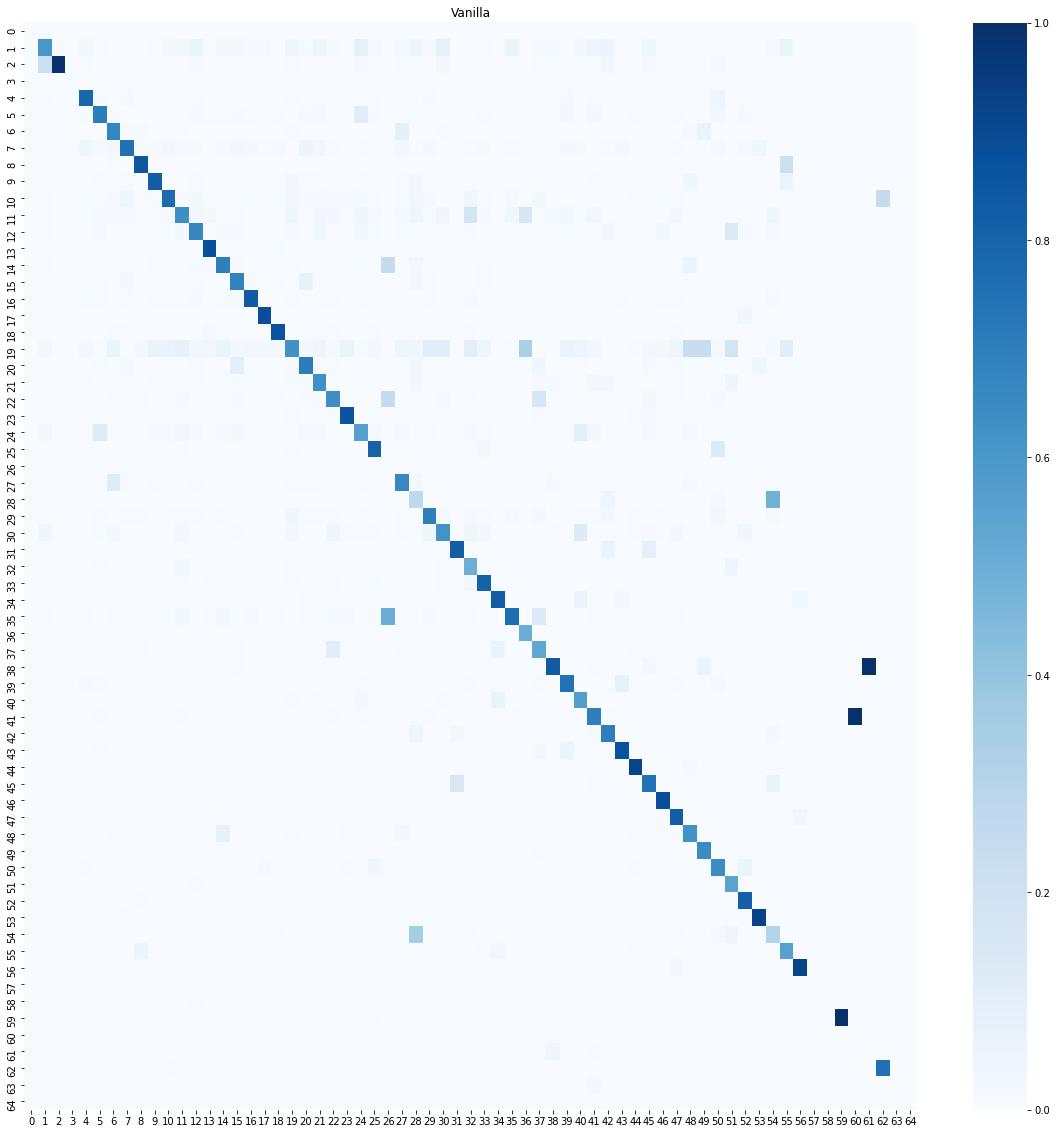

In [20]:
cor_mat = create_correlation_plot(translator.out_lang, 'predictions/prediction_vanilla.csv', 'Vanilla')

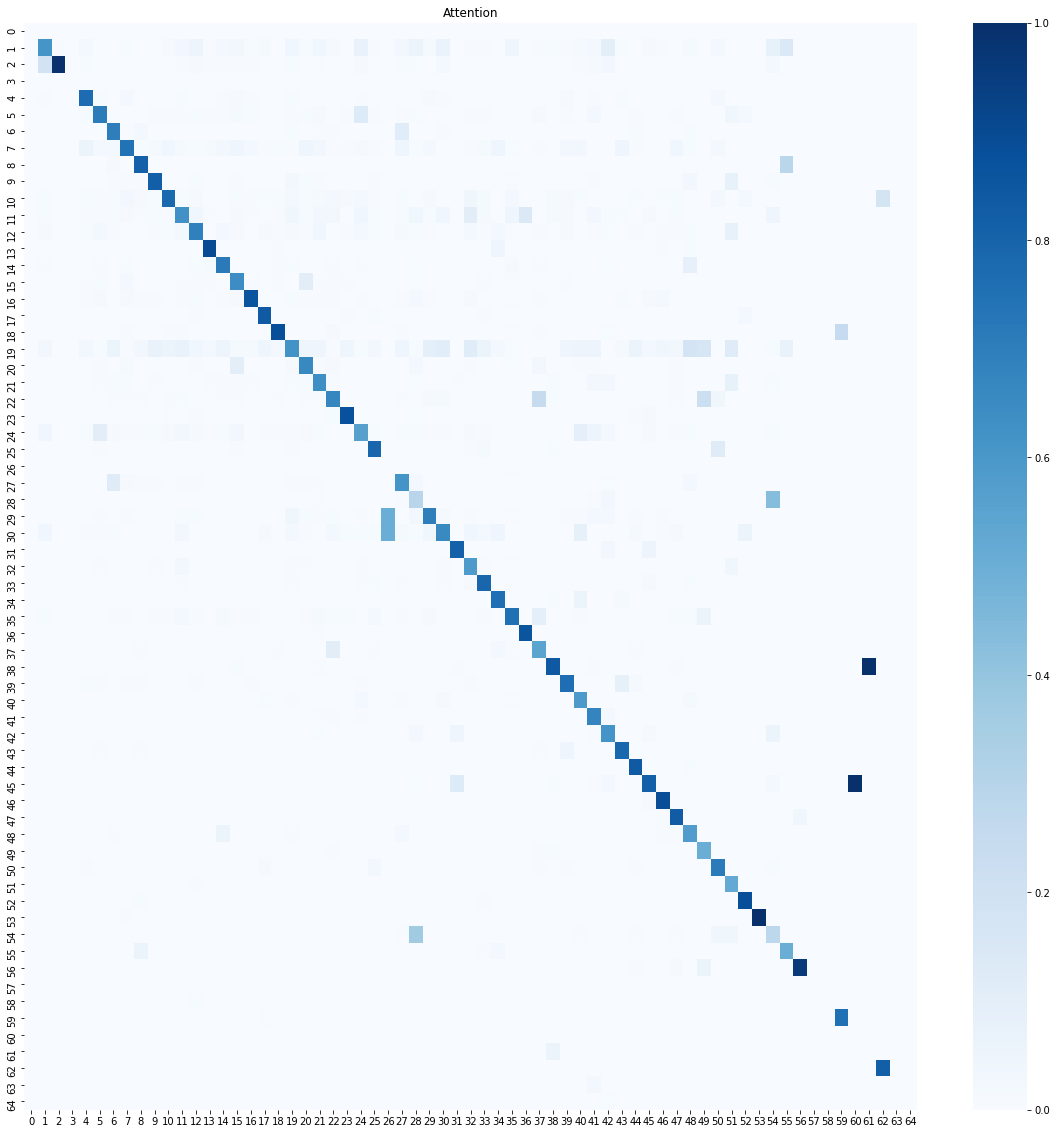

In [16]:
cor_mat = create_correlation_plot(translator.out_lang, 'predictions/prediction_attention.csv', 'Attention')

In [26]:
# log image in wandb
wandb.init(project='rnn-first-proj')
wandb.log({'correlation_plot_vanilla': wandb.Image('attn.png')})

In [17]:
class_labels = translator.out_lang.chars

run = wandb.init(project="rnn-first-proj")
cor_mat = np.array(cor_mat)
fields = {
	"Actual": "Actual",
	"Predicted": "Predicted",
	"nPredictions": "nPredictions",
}

data = []
for i in range(len(cor_mat)):
	for j in range(len(cor_mat)):
		data.append([class_labels[i], class_labels[j], cor_mat[i][j]])

wandb.log({"conf_mat" : wandb.plot_table(
        "wandb/confusion_matrix/v1",
        wandb.Table(columns=["Actual", "Predicted", "nPredictions"], data=data),
        fields,
        {"title": ""}
    )})
run.finish()

In [18]:
test_preds = pd.read_csv('predictions/prediction_vanilla.csv')
test_preds.columns = ['input_seq', 'target_seq', 'output_seq']

acc = 0
for i in range(len(test_preds)):
	if test_preds['target_seq'][i] == test_preds['output_seq'][i]:
		acc += 1

print(acc/len(test_preds))

0.3333333333333333


In [19]:
test_preds = pd.read_csv('predictions/prediction_attention.csv')
test_preds.columns = ['input_seq', 'target_seq', 'output_seq']

acc = 0
for i in range(len(test_preds)):
	if test_preds['target_seq'][i] == test_preds['output_seq'][i]:
		acc += 1

print(acc/len(test_preds))

0.3418803418803419


In [24]:
test_preds1 = pd.read_csv('predictions/prediction_vanilla.csv')
test_pred2 = pd.read_csv('predictions/prediction_attention.csv')

test_preds1.columns = ['input_seq', 'target_seq', 'output_seq']
test_pred2.columns = ['input_seq', 'target_seq', 'output_seq']

for i in range(len(test_preds1)):
	if test_preds1['target_seq'][i] == test_preds1['output_seq'][i] and test_preds1['target_seq'][i] != test_pred2['output_seq'][i]:
		print(test_preds1['input_seq'][i],  test_preds1['output_seq'][i], test_pred2['output_seq'][i])

mahanubhaavone મહાનુભાવોને મહાનુભવોને
sandowayela સંડોવાયેલા સંદોવાયેલા
bhaiao ભાઈઓ ભાઇઓ
bhaiaoni ભાઈઓની ભાઇઓની
mishra મિશ્રા મિશ્ર
kabajama કબજામાં કબાજમાં
maheyshbhaai મહેશભાઈ મહેશભાઇ
kareeye કરીયે કરીએ
kalaapreymee કલાપ્રેમી કલાપ્રેમીય
patana પટના પાટાના
modhaaman મોઢામાં મોધામાં
maharajnee મહારાજની મહારજની
sheevjina શિવજીના શીવજીના
sthagitapane સ્થગિતપણે સ્થગિતાપણે
fetty ફેટી ફેટ્ટી
baraabari બરાબરી બારાબરી
bilaadinun બિલાડીનું બીલાડીનું
pidit પીડિત પીડીત
anoogamee અનુગામી અનુગમી
quick ક્વિક ક્વીક
atlantic એટલાન્ટિક અટ્લાન્ટિક
pradhaanamantriono પ્રધાનમંત્રીઓનો પ્રધાનામંત્રીઓન
bhanavavamam ભણાવવામાં ભણાવવામમ
dravyanu દ્રવ્યનું દ્રવ્યાનું
mahoodo મહુડો મહુદો
kelavavee કેળવવી કેલાવવી
chukavanina ચૂકવણીના ચુકવણીના
chijvastuona ચીજવસ્તુઓના ચીજવાસતુઓના
bhansali ભંસાલી ભણસાળી
anamatano અનામતનો અનામાતનો
kortsmanthee કોર્ટ્સમાંથી કોર્ટસ્માંથી
barai બરાઈ બરાઇ
bardaa બરડા બરદા
jain જૈન જેન
modhaamaa મોઢામાં મોધામાં
yathaarth યથાર્થ યથારથ
postarsmaanthee પોસ્ટર્સમાંથી પોસ્ટરસ્માંથી
parinamama

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [ ]:
word = 'jigokuraku'
output_words, attentions = trans.translate(word)

# take only len(word) values from each row in attention

n_att = torch.zeros(len(word), len(word))
for i in range(len(word)):
    n_att[i] = attentions[i][:len(word)]
	 

plt.matshow(n_att.numpy())